## Исследование данных о российском кинопрокате



**Цель анализа:**  выявление трендов в российском кинопрокате.

**Ключевые вопросы:** 
* Динамика развития рынка кинопроката в России;
* Влияние возрастного рейтинга и жанра на популярность в России;
* Эффективность господдержки в кинопрокате;

Данные для анализа предоставлены в файлах "mkrf_movies" и "mkrf_shows.csv". <br>

**Описание данных** <br>
Таблица *mkrf_movies* содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений. 

    title — название фильма;
    puNumber — номер прокатного удостоверения;
    show_start_date — дата премьеры фильма;
    type — тип фильма;
    film_studio — студия-производитель;
    production_country — страна-производитель;
    director — режиссёр;
    producer — продюсер;
    age_restriction — возрастная категория;
    refundable_support — объём возвратных средств государственной поддержки;
    nonrefundable_support — объём невозвратных средств государственной поддержки;
    financing_source — источник государственного финансирования;
    budget — общий бюджет фильма;
    ratings — рейтинг фильма на КиноПоиске;
    genres — жанр фильма.

Таблица *mkrf_shows* содержит сведения о показах фильмов в российских кинотеатрах.

    puNumber — номер прокатного удостоверения;
    box_office — сборы в рублях.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Устанавливаем полное отображение всех столбцов
pd.set_option('display.max_columns', None)

### Шаг 1. Откроем файлы с данными и объедините их в один датафрейм

In [2]:
# Открываем необходимые файлы
try:
    data = pd.read_csv('local.csv')
except:
    data = pd.read_csv(
         r'https://code.s3.yandex.net/***.csv')
    
try:
    data_shows = pd.read_csv('local2.csv')
except:
    data_shows = pd.read_csv(
         r'https://code.s3.yandex.net/***.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [4]:
data_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Для анализа данных необходимо объединить две таблицы, чтобы в единой таблице были данные по фильму и объем сборов (если известно). <br> 
Ключем для объединения станет столбец 'puNumber'. Нужно привести к единому типу, предпочтительней int64.

In [5]:
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"


In [6]:
# Проверяем столбец на не цифровые данные (пропусков нет согласно info)
data[~data.puNumber.str.isdigit()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Со значением 'нет' все понятно, а вот со строкой 804 надо разобраться
data.loc[804]['puNumber']

' 111004112'

In [8]:
# Удаляем все лишние пробелы в начале и конце строки столбца, а значение 'нет' заменяем на '0'
data['puNumber'] = data['puNumber'].str.strip().replace('нет', '0')

In [9]:
# Преобразуем данные 'puNumber' в int64
data['puNumber'] = data['puNumber'].astype('int64') 

# Объеденяем данные из двух файлов по ключу 'puNumber'
data = data.join(data_shows.set_index('puNumber'), on='puNumber', how='left')

In [10]:
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


### Шаг 2. Предобработка данных

In [11]:
# Для удобной работы переименуем столбцы к общепринятому виду
data = data.rename(columns={'puNumber': 'pu_number'})

#### Шаг 2.1. Проверка типов данных

Проверим типы данных и изменим их при необходимости

In [12]:
data.info() # Данные по итоговом ДатаФрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Для проверки данных (строковые значения, где предполагаем числовое), оптимизации и удобства работы с данными произведем замену типа данных в следующих столбцах:
1) show_start_date - из 'object' в 'datetime64'  
2) refundable_support - из 'object' в 'Int64'   
3) nonrefundable_support - из 'object' в 'Int64'   
4) budget - из 'object' в 'Int64'   
5) ratings - из 'object' в 'float64'   
6) box_office - из 'float64' в 'Int64'   
<br><br>
Для значений в которых десятичная часть не важна - отбросим ее. <br>
Т.к. датафрейм небольшой, можно оставить 64 битные значения.

In [13]:
# Выполним преобразование из 'object' в 'Int64'
columns = ('refundable_support', 'nonrefundable_support', 'budget')

for col in columns:
    data[col] = data[col].astype('Int64')

In [14]:
# Выполним преобразование из 'float64' в 'Int64'
data['box_office'] = data['box_office'].round().astype('Int64')

In [15]:
# Определяем почему 'ratings' это 'object', а не float
# Находим все значения (type str) не соответствующие ввиду 'x.x', x - любое кол-во цифр
non_decimal = data['ratings'].dropna()[~data['ratings']. \
                    dropna().str.match(r'^\d+(\.\d+)?$')] # исключаем пропуски
# где '^\d+(\.\d+)?$' регулярное выражение
non_decimal.head()

259     99%
811     28%
1053    97%
1341    99%
1805    99%
Name: ratings, dtype: object

Часть значений записаны в процентах, а не в десятичном значении. Заменим процентные значения на десятичные

In [16]:
# Напишим функцию для замены значений которые не соответствуют шаблону и не являются пустыми
def replace_non_decimal(value):
    if pd.isna(value): # если значение пустое
        return value
    elif re.match(r'^\d+(\.\d+)?$', value): # если значение соответствует шаблону
        return value
    else:
        return float(value.replace('%', ''))/10 # удаляем символ %, преобразуем в float и делим на 10
    
data['ratings'] = data['ratings'].transform(replace_non_decimal) # выполняем преобразование значений

In [17]:
# Выполним преобразование из 'object' в 'float64'
data['ratings'] = data['ratings'].astype('float64')

In [18]:
# Выполним преобразование из 'object' в 'datetime64'
data['show_start_date'] = pd.to_datetime(data['show_start_date'])

In [19]:
data.info() # Данные преобразований

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   pu_number              7486 non-null   int64              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    Int64              
 10  nonrefundable_support  332 non-null    Int64              
 11  budget                 332 non-null    Int64            

#### Шаг 2.2. Изучим пропуски в датафрейме

In [20]:
# выведем кол-во пропусков по столбцам
data.isna().sum()

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   967
genres                    976
box_office               4328
dtype: int64

In [21]:
# Пропуски по столбцам студия-изготовитель, режиссер, продюсер, жанры заполним значением 'no_data' 
no_data_list = ['film_studio', 'director', 'producer', 'genres']

data[no_data_list] = data[no_data_list].fillna('no_data')

In [22]:
# Пропуски по столбцу реитинг заполним значением -1 
data['ratings'] = data['ratings'].fillna(-1)

In [23]:
# Проверим 2 пропуска по страна-производитель
data[data['production_country'].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,<NA>,<NA>,<NA>,NaN,7.2,"детский,комедия",194527
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,no_data,NaN,no_data,no_data,«0+» - для любой зрительской аудитории,<NA>,<NA>,<NA>,NaN,4.0,"мультфильм,комедия",<NA>


In [24]:
# Т.к. значений всего два и мы знаем страну-производитель, то можем заполнить корректно
data['production_country'] = data['production_country'].fillna('Россия')

In [25]:
# Т.к. refundable_support, nonrefundable_support, budget и financing_source взаимосвязаны
# проверим случае когда 1 значение не пустое

(
    (data['refundable_support'].notna())
        & (
        data['nonrefundable_support'].isna() | data['budget'].isna() 
            | data['financing_source'].isna()
         )
).sum()

0

Таких значений нет, значит любое пустое значение в этих столбцах автоматически означает пропуски в других

In [26]:
# Пропуски refundable_support, nonrefundable_support 
# - заполняем 0 (государственного российского финансирования не было)
data[['refundable_support', 'nonrefundable_support']] = \
        data[['refundable_support', 'nonrefundable_support']].fillna(0)

In [27]:
# Пропуски financing_source - заполняем 'ЧИИФ' (Частный или Иностраный Источник Финансирования)
data['financing_source'] = data['financing_source'].fillna('ЧИИФ')

Пропуски в столбце 'budget' оставим пустые т.к. в рамках анализа установить объем бюджета нет возможности, необходимо сохранить числовое значение и необходимо исключить данные из выборки по объему бюджета. <br>
Аналогично с 'box_office' (кассовые сборы). <br>
Большинство пропусков можно заполнить данными из внешних источников, например API КиноПоиск. Но это выходит за рамки поставленных задач.

In [28]:
data.isna().sum() # Проверяем итоговые пропуски

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                 0
production_country          0
director                    0
producer                    0
age_restriction             0
refundable_support          0
nonrefundable_support       0
budget                   7154
financing_source            0
ratings                     0
genres                      0
box_office               4328
dtype: int64

#### Шаг 2.3. Изучим дубликаты в датафрейме и удалим их по необходимости

In [29]:
# Создадим столбец с измененными символами в названиями 
data['title_replace'] = (
    data['title']
    .str.replace('ё', 'е')
    .str.replace('й', 'и')
            ) 
# Проверим кол-во дубликатов по оригинальным названиям и с изменениями
( data[data.duplicated('title')]['title'].count(), 
            data[data.duplicated('title_replace')]['title_replace'].count() )

(714, 717)

Кол-во дублей по измененным названием на 3 больше, чем по оригинальным. В дальнейшем для поиска дубликатов будем работать с ним. <br>

In [30]:
# Удалим спец символы и доп донные из название (какие смогли обнаружить)
# Удаляем все что после \, год в формате (хххх), в конце точка, пробелы в начале и конце

def prepare_title (text):
    # Удаляем годы из 4х цифр в скобках
    text = re.sub(r'\(\d{4}\)', "", text)
    # Удаляем символы после точки в конце строки
    text = re.sub(r'\.\s*$', "", text)
    # Удаляем оставшиеся отрезки после символов / и перед ними
    text = re.sub(r'/.*$', "", text)
    text = text.strip() # Под конец просто удаляем не нужные пробелы в начале и конце
    return text

data['title_replace'] = data['title_replace'].transform(prepare_title)

##### Присваивание единного возрастного рейтинга

Перед обработкой дубликатов еще необходимо нормализировать возрастной рейтинг для всех дубликатов. Для этого всем фильмам присвоим самый поздний возрастной рейтинг

In [31]:
# Создаем смежную таблицу с указанием большей даты
pivot_age_rest = data.pivot_table(index='title_replace', 
                                values=('show_start_date'),
                                aggfunc={'show_start_date':'max'}).reset_index()

#Добавляем возрастные ограничения для этой даты
pivot_age_rest['age_restriction'] = pivot_age_rest.merge(data, 
                                   left_on=('title_replace', 'show_start_date'), 
                                   right_on=('title_replace', 'show_start_date')
                         )['age_restriction']

In [32]:
# Создаем Series со значениями последнего возрастного рейтинга
ser_temp = data.merge(pivot_age_rest, how='left',
                  left_on='title_replace', 
                  right_on='title_replace'
                         )['age_restriction_y']

In [33]:
# Выставляем значения возрастного рейтинга одинаковым для всех фильмов (самый поздний)
data['age_restriction'] = ser_temp

##### Удаление по номеру прок. удостоверения

In [34]:
# Проверим дубликаты по номеру удостоверения 
data[data.duplicated(('pu_number'), keep=False) 
     ].sort_values('title_replace')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace
5068,Анализируй то!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,6.8,"комедия,криминал",<NA>,Анализируи то!
5067,Анализируй это!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«12+» - для детей старше 12 лет,0,0,<NA>,ЧИИФ,7.4,"комедия,криминал",<NA>,Анализируи это!
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,7.6,"драма,мелодрама,история",<NA>,Иоанна - женщина на папском престоле
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00+00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,7.0,"мелодрама,комедия",<NA>,Как жениться и остаться холостым


Это разные фильмы, которым по ошибки присвоен одинаковые номера прокатного удостоверения. Заменим в них номера удостоверения на 0 и дату премьеры на 1900 год

In [35]:
# В дублирующихся номерах прок. уд. заменим номер прок.уд на 0, а дату премьеры на 1900 год
data.loc[data.duplicated(('pu_number'), keep=False), ('pu_number', 'show_start_date')
        ] = 0, pd.Timestamp('1900-01-01T12:00:00.000Z', tz='UTC')

##### Удаление общих дубликатов

In [36]:
# Удалим дубликаты по все столбцам кроме номера прок. уд. и даты премьеры

full_dup_list = list(data.columns) # создаем список столбцов
for x in ('title', 'pu_number', 'show_start_date'):
    full_dup_list.remove(x) # удаляем ненужные столбцы
    
data = data.drop_duplicates(subset=full_dup_list)

##### Удаление дубликатов с пустым бюджетом

In [37]:
# Удалим лишние пробелы в данных 'film_studio' и 'producer'
data[['film_studio', 'producer']] = data[['film_studio', 'producer']].transform(lambda x: 
                                              x.str.strip()
                                             )

In [38]:
# удалим дубликаты с пустым бюджетом (оставим только те дубликаты, где кас. сборы указаны)
notfull_dup_list = full_dup_list.copy() # создаем копию списка столбцов для поиска дубликатов
for col in ('box_office', 'film_studio', 'producer', 'refundable_support',
            'nonrefundable_support', 'budget', 'financing_source'):
    notfull_dup_list.remove(col) # удаляем столбец для учета дубликатов

'''
Для получения фильтра на удаления используем инверсию 
(находим данные которые нужно удалить, потом инвертируем значения 
и получаем список, который надо оставить).
Список (до инверсии) - дубликаты по столбцам (вывод всех значений) И 
пустые значения в 'box_office' (чтобы оставить те значения, где указаны сборы)
'''
for val in ('first', 'last'): # проходим в два этапа, чтобы не удалить дубликаты без данных о сборах
    data = data[~(
        data.duplicated(notfull_dup_list, keep=val) 
                  & (data['box_office'].isna())
                    )]

##### Удаление по стране производителю

Отдельно удалим фильмы где есть различия по стране и не указан кассовый сбор. Записаны по разному, но фильм один

In [39]:
# Удаляем дубликаты по стране-производитель
notfull_dup_list.remove('production_country') # удаляем столбец для учета дубликатов 

data = data[~(
        data.duplicated(notfull_dup_list, keep='first') 
                  & (data['box_office'].isna())
             )]

Выполним проверку по основным показателям

In [40]:
# Проверяем дубликаты по основным показателям
data[(
    (data.duplicated((('title_replace', 'type', 'director')), keep=False)
                   & (data['box_office'].isna()))
    )].sort_values('title_replace')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace


Дубликатов нет, осталось только разобратся с дублями где указаны сборы.

##### Обработка кассовых сборов и удаление дубликатов

In [41]:
# Выводим первые 10 дублей с указанием сборов
data[data.duplicated((('title_replace', 'type', 'director')
                     ), keep=False)].sort_values('title_replace').head(10)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace
1984,Weekend (Уик-энд).,111008914,2014-08-13 12:00:00+00:00,Художественный,"ООО ""Киностудия ""ВЕРТИКАЛЬ""",Россия,С.Говорухин,"С.Говорухин, Е.Маскина",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,7.4,мелодрама,38044,Weekend (Уик-энд)
1481,Weekend (Уик-энд),111014713,2013-12-24 12:00:00+00:00,Художественный,"ООО ""Киностудия ""ВЕРТИКАЛЬ""",Россия,С.Говорухин,"С.Говорухин, Е.Маскина",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,7.4,мелодрама,7755,Weekend (Уик-энд)
885,Арктика 3D,126003112,2012-10-18 12:00:00+00:00,Прочие,"МакГиливрэй, Фримен Филмз, Аймакс",США,Грэг МакГиливрэй,"Грег МакГиливрэй, Шон МакГиливрэй",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,7.7,"документальный,короткометражка",103210,Арктика 3D
887,Арктика 3D,126003016,2016-07-01 12:00:00+00:00,Прочие,"МакГиливрэй, Фримен Филмз, Аймакс",США,Грэг МакГиливрэй,"Грег МакГиливрэй, Шон МакГиливрэй",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,7.7,"документальный,короткометражка",45300,Арктика 3D
1208,Аэротачки,124002412,2012-10-05 12:00:00+00:00,Анимационный,"Ти Филмз, Ламлайт Анимейшн Студиос",США,Тони Тэнг,"Джефф Боулер, Пегги Ли, Чарли Вонг Уинг Фанг",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,4.1,мультфильм,9530,Аэротачки
1209,Аэротачки,224013814,2014-10-07 12:00:00+00:00,Анимационный,"Ти Филмз, Ламлайт Анимейшн Студиос",США,Тони Тэнг,"Джефф Боулер, Пегги Ли, Чарли Вонг Уинг Фанг",«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,4.1,мультфильм,1230,Аэротачки
2608,Багровый пик,221027316,2016-06-10 12:00:00+00:00,Художественный,Леджендари Пикчерз,США - Канада,Гильермо дель Торо,"Каллум Грин, Джон Дж. ДжашниГильельмо дель Торо",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,6.6,"ужасы,фэнтези,триллер",1200,Багровыи пик
2610,Багровый пик,121015215,2015-07-23 12:00:00+00:00,Художественный,Леджендари Пикчерз,США - Канада,Гильермо дель Торо,"Каллум Грин, Джон Дж. ДжашниГильельмо дель Торо",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,6.6,"ужасы,фэнтези,триллер",294842966,Багровыи пик
2633,Бегущий в лабиринте: Испытание огнем /По произ...,121016215,2015-07-31 12:00:00+00:00,Художественный,"ХХ век Фокс, Готэм Групп, Тэ Эс Гэ Интертейнме...",США,Уэс Болл,"Мартин Бауэн, Эллен Годсмит-Вейн, Вик Годфри",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,6.1,"фантастика,боевик,триллер",484055453,Бегущии в лабиринте: Испытание огнем
2632,Бегущий в лабиринте: Испытание огнем /По произ...,221050715,2015-12-17 12:00:00+00:00,Художественный,"ХХ век Фокс, Готэм Групп, Тэ Эс Гэ Интертейнме...",США,Уэс Болл,"Мартин Бауэн, Эллен Годсмит-Вейн, Вик Годфри",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,6.1,"фантастика,боевик,триллер",1900,Бегущии в лабиринте: Испытание огнем


Тут многие фильмы в разных годах поступили в прокат. Предположительно, были осуществлены повторные показы. Есть три основных варианта обработки:
1) Если оставить как есть, то получится, что фильмы по жанру пользуются меньше популярностью в более поздние года. Хотя фактически это будет связано с тем, что на повторный показ ходят меньше зрителей. <br>
2) Если просуммировать показатели сборов и удалить повторный показ, то будет искажение по годам. <br>
3) Если удалить повторные показы без суммирования, то уменьшится общий сбор фильма. <br>


**Будем использовать первый вариант** т.к. он в общем анализе покажет самые достоверные данные, но только для дубликатов с разницей более 12 месяцев. <br><br>
Алгоритм обработки таких значений: если разница между показами меньше 12 месяцев (365 дней), то суммируем значение сборов и удаляем последние значение; если разница равна или больше 12 месяцев, то оставляем без изменений.

In [42]:
# Для удобства создаем строку-индексацию 
data_bool_index = data.duplicated(('title_replace', 'type', 'director'), keep=False) 

# Создаем смежную таблицу с указанием большей и меньшей датой дубликата
pivot_box_period = data[data_bool_index].pivot_table(index='title_replace', 
                                values=('show_start_date', 'box_office'),
                                aggfunc={'show_start_date':('max', 'min'), 'box_office':'sum'}
                                                    ).droplevel(0, axis=1).reset_index()
# .droplevel(0, axis=1) - удаляет 'первый' заголовок

# Добавляем разницу в месяцах между датами
pivot_box_period['period_year'] = ( 
(pivot_box_period['max']-pivot_box_period['min']) / pd.Timedelta(1, 'D') / 365)

In [43]:
# Создаем Series со значениями суммы для минимальной даты, где меньше года разница
ser_temp = data.merge(pivot_box_period[pivot_box_period['period_year']<1], 
                      how='left',
                  left_on=('title_replace','show_start_date'), 
                  right_on=('title_replace', 'min')
                         )['sum']
ser_temp.index = data.index  # устанавливаем совпадение индексов

# По выборке где указанна сумма для замены в series, выполняем замену сборов на суммарное
data.loc[ser_temp.notna(), 'box_office'] = ser_temp[ser_temp.notna()]

Мы сделали замену сборов на суммарные сборы, для фильмов дубликатов, где разница между прокатными удостоверениям меньше года. Осталось лишь удалить дубликаты (с большей датой) с разницей меньше года.

In [44]:
# Создаем Series со значениями даты для максимальной даты, где меньше года разница
ser_temp = data.merge(pivot_box_period[pivot_box_period['period_year']<1], 
                      how='left',
                  left_on=('title_replace','show_start_date'), 
                  right_on=('title_replace', 'max')
                         )['max'] # столбец не важен, нам будут нужны только не пустые индексы
ser_temp.index = data.index  # устанавливаем совпадение индексов

In [45]:
# Производим удаление строк по индексам, где не пустые значения в ser_temp
data = data.drop(ser_temp[ser_temp.notna()].index)

In [46]:
# Выводим кол-во оставшихся дублей (
# где указан бюджет и повторный показ (разница между показами больше года))
data[data.duplicated((('title_replace', 'type', 'director')
                     ), keep='first')]['title'].count()

11

In [47]:
data.shape[0] # узнаем кол-во оставшихся строк

6780

**Промежуточный итог к шагу 2.3** <br>
* Из 7486 строк осталось 6780
* Остались дубликаты (11 фильмов, 22 строки), где были повторные показы (разница между показами более года) и есть данные по кассовым сборам
* Повторные показы без учета кассовых сборов были удалены (если такие были) т.к. в них мало ценности
* В столбце 'show_start_date' указана не дата премьеры (как указано в ТЗ), а дата выдачи прокатного удостоверения [подробное описание ниже](#Дополнительно-по-дате.).

#### Шаг 2.4. Изучим категориальные значения

Категориальными столбцами являются:
* type
* production_country
* age_restriction
* financing_source
* genres

##### Столбец 'type'

In [48]:
# Проверяем значения столбца 'type'
data['type'].value_counts()

Художественный                3904
 Художественный               1380
Анимационный                   771
Прочие                         393
Документальный                 278
Научно-популярный               52
 Анимационный                    1
Музыкально-развлекательный       1
Name: type, dtype: int64

In [49]:
data['type'] = data['type'].str.strip() # Удаляем лишние пробелы 

In [50]:
# 'Музыкально-развлекательный' переименуем в 'Прочие'
data.loc[data['type']=='Музыкально-развлекательный', 'type'] = 'Прочие'

##### Столбец 'production_country'

In [51]:
# Проверяем значения столбца 'production_country'
data['production_country'].value_counts()

Россия                                       1805
США                                          1762
СССР                                          344
Франция                                       277
Великобритания                                240
                                             ... 
Сербия - Великобритания - США                   1
Франция-Италия-Испания-Венгрия                  1
США - Ирландия - Великобритания - Франция       1
Бельгия-Нидерланды                              1
Австралия, Канада                               1
Name: production_country, Length: 947, dtype: int64

Разных значений очень много (947 шт). Приведем к общему ввиду - "{country1}, {country2}, .. , {country_n}" с сортировкой стран в алфавитном порядке. <br>
Только для начала создадим столбец с указанием первой страны производителя. Зачастую *первой страной прописывают страну с самым большим вкладом в создании фильма*. Не всегда так, но **будем принимать** для анализа, что это условие соблюдалось.

In [52]:
# Создаем столбец с первым названием страны-производителя (считаем основной)
# Используем регулярные выражение re.split(r'[-,]', x) - разделить строку x по '-' или ','
data['production_country_first'] = data['production_country'].transform(lambda x: 
                                     re.split(r'[-,]', x)[0].strip()
                                                  )

In [53]:
'''
Разделяем строку на список по регулярному выражению (
re.split(r'[-,]', x) - разделить строку x по '-' или ',')
При помощи генератора перебираем значения в нем и удаляем в каждом значении пробелы в начале и конце
Упаковываем в список, сортируем. Далее join из списка собирает строку по разделителю ', '.
'''

data['production_country'] = data['production_country'].transform(lambda x: 
                                        ', '.join( 
                                    sorted( [elem.strip() for elem in re.split(r'[-,]', x)] )  
                                                  ))

In [54]:
data['production_country'].value_counts()

Россия                                    1805
США                                       1764
СССР                                       374
Франция                                    278
Великобритания                             241
                                          ... 
Пуэрто Рико, США                             1
Индия, ОАЭ, США                              1
Бельгия, Германия, Люксембург, Франция       1
Пакистан                                     1
Австрия, Германия, Италия, Франция           1
Name: production_country, Length: 673, dtype: int64

##### Столбец 'age_restriction'

In [55]:
data['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2510
«12+» - для детей старше 12 лет           1490
«18+» - запрещено для детей               1437
«0+» - для любой зрительской аудитории     732
«6+» - для детей старше 6 лет              611
Name: age_restriction, dtype: int64

Возрастные категории в порядке, изменения не требуется. Фактическую обработку [произвели](#Присваивание-единного-возрастного-рейтинга) в шаге 2.3.

##### Столбец 'financing_source'

In [56]:
data['financing_source'].value_counts()

ЧИИФ                                6448
Министерство культуры                164
Фонд кино                            146
Министерство культуры, Фонд кино      22
Name: financing_source, dtype: int64

Категории источника финансирования в порядке, изменения не требуется

##### Столбец 'genres'

In [57]:
data['genres'].value_counts()

no_data                          966
драма                            454
комедия                          329
мелодрама,комедия                180
драма,мелодрама                  170
                                ... 
комедия,история,драма              1
комедия,военный,музыка             1
приключения,боевик,триллер         1
детектив,мелодрама,фэнтези         1
приключения,детектив,семейный      1
Name: genres, Length: 742, dtype: int64

Для начала создадим столбец с указанием первого. Зачастую *первым жанром указывают основной жанр*. Не всегда так, но **будем принимать** для анализа, что это условие соблюдалось.

In [58]:
# Создаем столбец с первым названием жанра (считаем основной)
# Используем регулярные выражение re.split(r'[-,]', x) - разделить строку x по '-' или ','
data['genres_first'] = data['genres'].transform(lambda x: 
                                     re.split(r'[-,]', x)[0].strip()
                                                  )

In [59]:
data['genres_first'].value_counts()

драма              1556
no_data             966
комедия             648
боевик              517
ужасы               507
мультфильм          474
триллер             474
фантастика          358
мелодрама           330
фэнтези             275
документальный      200
аниме                71
мюзикл               56
приключения          54
детектив             52
военный              42
криминал             38
биография            32
семейный             30
детский              28
история              22
короткометражка      13
концерт              11
спорт                 9
музыка                7
вестерн               6
для взрослых          2
фильм                 1
реальное ТВ           1
Name: genres_first, dtype: int64

In [60]:
# Выведем 'сомнительные' жанры 
nopup_genres_list = ['реальное ТВ', 'фильм']

data.query('genres_first in @nopup_genres_list')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace,production_country_first,genres_first
2048,Страх сцены.,121019414,2014-09-03 12:00:00+00:00,Художественный,"Серендипити Поинт Филмз, Ситизен Джоунз",Канада,Джером Сейбл,"Ари Лантос, Джонас Белл Пашт",«0+» - для любой зрительской аудитории,0,0,<NA>,ЧИИФ,7.6,"фильм-нуар,триллер,детектив",1700,Страх сцены,Канада,фильм
7152,Битва,111013619,2019-08-29 12:00:00+00:00,Художественный,"ООО ""ТПО ""РОК""",Россия,А.Аббасов,"А.Учитель, К.Саксаганская",«16+» - для детей старше 16 лет,28000000,25000000,80000000,"Министерство культуры, Фонд кино",5.6,реальное ТВ,32721103,Битва,Россия,реальное ТВ


In [61]:
# Заменим в ручном режиме
data.loc[2048, ['genres_first']] = 'триллер'
data.loc[7152, ['genres', 'genres_first']] = 'no_data'

Приведем к общему ввиду - "{genre1}, {genre2}, .. , {genre_n}" с сортировкой жанров в алфавитном порядке.

In [62]:
'''
Разделяем строку на список по регулярному выражению (
re.split(r'[-,]', x) - разделить строку x по '-' или ',')
При помощи генератора перебираем значения в нем и удаляем в каждом значении пробелы в начале и конце
Упаковываем в список, сортируем. Далее join из списка собирает строку по разделителю ', '.
'''

data['genres'] = data['genres'].transform(lambda x: 
                                        ', '.join( 
                                    sorted( [elem.strip() for elem in re.split(r'[-,]', x)] )  
                                                  ))

In [63]:
data['genres'].value_counts()

no_data                               967
драма                                 454
комедия                               329
комедия, мелодрама                    232
драма, комедия, мелодрама             191
                                     ... 
боевик, мелодрама                       1
детектив, приключения, триллер          1
история, комедия, приключения           1
аниме, короткометражка, мультфильм      1
детектив, нуар, триллер, фильм          1
Name: genres, Length: 472, dtype: int64

#### Шаг 2.5. Проверим количественные значения

Количественными столбцами являются:
* refundable_support
* nonrefundable_support
* budget
* ratings
* box_office

Столбец budget уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. 

##### Данные по бюджетным средствам

In [64]:
data[['refundable_support', 'nonrefundable_support', 'budget']].describe()

,refundable_support,nonrefundable_support,budget
count,6.780000e+03,6.780000e+03,3.320000e+02
mean,5.809735e+05,2.398479e+06,1.272297e+08
std,6.072070e+06,1.695303e+07,1.885883e+08
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,4.200000e+07
50%,0.000000e+00,0.000000e+00,6.864992e+07
75%,0.000000e+00,0.000000e+00,1.419853e+08
max,1.800000e+08,4.000000e+08,2.305074e+09


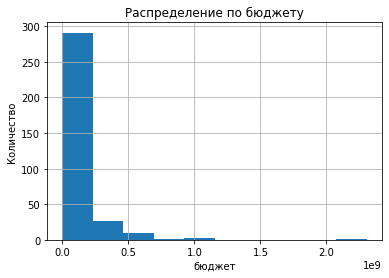

In [65]:
# Построение гистограммы для бюджета
fig, ax = plt.subplots()
data['budget'].plot(kind='hist', title='Распределение по бюджету', 
                    grid=True);
ax.set_ylabel('Количество');
ax.set_xlabel('бюджет');

In [66]:
# Проверим самые большие бюджеты
data[data['budget']>0.7*10**9]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace,production_country_first,genres_first
5437,Матильда,111005717,2017-08-17 12:00:00+00:00,Художественный,"ООО ""ТПО ""РОК"", ООО ""Матильда""",Россия,А.Учитель,"А.Учитель, А.Достман, В.Винокур",«16+» - для детей старше 16 лет,110000000,190000000,1032905957,Фонд кино,7.7,"комедия, семейный, фэнтези",511775548,Матильда,Россия,фэнтези
7114,Тайна Печати Дракона,111012819,2019-09-12 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""СТВ""; ООО ""РФГ Корп""; ООО ""...","Китай, Россия",О.Степченко,"С.Сельянов, А.Петрухин",«12+» - для детей старше 12 лет,180000000,90000000,2305074303,Фонд кино,5.8,"приключения, фэнтези",333597060,Таина Печати Дракона,Россия,приключения
7171,Грех,111014419,2019-08-31 12:00:00+00:00,Художественный,НО Фонд Андрея Кончаловского по поддержке кино...,"Италия, Россия",А.Михалков (псевдоним А.Кончаловский),НО Фонд Андрея Кончаловского по поддержке кино...,«18+» - запрещено для детей,0,60000000,779941965,Министерство культуры,6.9,"биография, драма, история",54243203,Грех,Россия,драма
7464,Союз спасения,111022019,2019-12-26 12:00:00+00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«18+» - запрещено для детей,100000000,400000000,980000000,Фонд кино,6.0,"биография, драма, история",717703186,Союз спасения,Россия,история
7474,Вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«16+» - для детей старше 16 лет,100000000,400000000,944000000,Фонд кино,5.7,"боевик, фантастика",<NA>,Вторжение,Россия,фантастика


Значения корректны

In [67]:
# Проверим бюджеты = 0
data[data['budget']==0]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace,production_country_first,genres_first
2053,14+,111023614,2014-12-19 12:00:00+00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,0,23000000,0,"Министерство культуры, Фонд кино",6.6,мелодрама,10234016,14+,Россия,мелодрама
2058,Дуxless 2,111000415,2015-01-26 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0,75000000,0,Фонд кино,6.6,драма,446163511,Дуxless 2,Россия,драма
2472,Воин (2015),111017315,2015-09-28 12:00:00+00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«16+» - для детей старше 16 лет,10000000,70000000,0,Фонд кино,7.8,"боевик, драма, криминал",196572438,Воин,Россия,боевик
2532,Бармен.,111009615,2015-05-26 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«6+» - для детей старше 6 лет,20000000,0,0,Фонд кино,6.2,"комедия, фэнтези",67418975,Бармен,Россия,комедия
2615,Савва. Сердце воина,114001715,2015-07-21 12:00:00+00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«16+» - для детей старше 16 лет,60000000,100000000,0,Фонд кино,4.6,"мультфильм, приключения, фэнтези",184487551,Савва. Сердце воина,Россия,мультфильм
2684,Тряпичный союз,111010215,2015-06-08 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«12+» - для детей старше 12 лет,0,59000000,0,Фонд кино,6.3,"драма, комедия",1957739,Тряпичныи союз,Россия,комедия
2788,Срочно выйду замуж,111017115,2015-09-30 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,0,35000000,0,Фонд кино,5.1,"комедия, мелодрама",72937783,Срочно выиду замуж,Россия,комедия
2874,Помню - не помню!,111004916,2016-03-01 12:00:00+00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«16+» - для детей старше 16 лет,0,6000000,0,Министерство культуры,4.3,комедия,15362931,Помню - не помню!,Россия,комедия
3047,Любовь с ограничениями,111008216,2016-04-29 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,19000000,51000000,0,Фонд кино,6.3,"комедия, мелодрама",70299052,Любовь с ограничениями,Россия,комедия
3565,Притяжение (2016),111018116,2016-12-16 12:00:00+00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«16+» - для детей старше 16 лет,0,250000000,0,Фонд кино,5.6,фантастика,1038321489,Притяжение,Россия,фантастика


Фильмов с указанием бюджета 0 руб - 17 штук. При это у них указаны данные по распределению возвратные/невозвратные средства. Произошло ошибка при заполнение базы данных. <br>
Проверим сколько значений где бюджет меньше суммы распред. средств.

In [68]:
# Выведем кол-во где бюджет меньше суммы распред. средств
data[data['budget'] < (data['refundable_support']+data['nonrefundable_support'])]['title'].count()

17

Таких значений тоже 17 шт. Значит произошла ошибка при заполнении данных бюджета и были внесены 0. Восстановить корректно данные нет возможности. **Удалим эти значения**, чтобы они не оказывали влияния на выборку среди фильмов с бюджетным финансированием.

In [69]:
# Удаляем строки где бюджет 0
data = data.drop((data[data['budget']==0]).index)

##### Столбец 'ratings'

In [70]:
data['ratings'].describe()

count    6763.000000
mean        5.410173
std         2.802974
min        -1.000000
25%         5.200000
50%         6.400000
75%         7.100000
max         9.900000
Name: ratings, dtype: float64

Данные рейтингов релевантные. Значение -1 указано для фильмов, где рейтинг неизвестен.

##### Столбец 'box_office'

In [71]:
data['box_office'].describe()

count    3.116000e+03
mean     7.661497e+07
std      2.411249e+08
min      0.000000e+00
25%      9.489975e+04
50%      2.342972e+06
75%      2.376798e+07
max      3.073569e+09
Name: box_office, dtype: float64

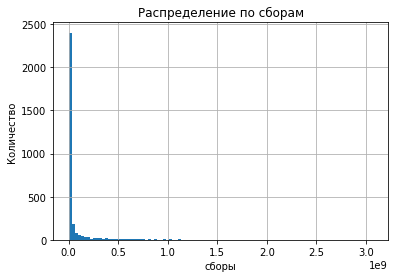

In [72]:
# Построение гистограммы для кас сборов
fig, ax = plt.subplots()
data['box_office'].plot(kind='hist', title='Распределение по сборам', 
                   bins=100, grid=True);
ax.set_ylabel('Количество');
ax.set_xlabel('сборы');

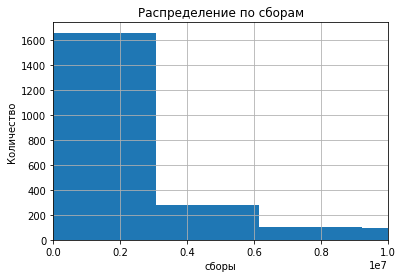

In [73]:
# Построение гистограммы для кас сборам
fig, ax = plt.subplots()
data['box_office'].plot(kind='hist', title='Распределение по сборам', 
                   bins=1000, xlim=(0, (0.01*10**9)), grid=True);
ax.set_ylabel('Количество');
ax.set_xlabel('сборы');

In [74]:
# Заменим значения 0 значениями -1 (чтобы сразу определять, что такие данные надо исключать)
data[data['box_office']==0]['title'].count()
data.loc[data['box_office']==0, 'box_office' ] = -1

In [75]:
data[data['box_office']<(1*10**4)] # меньше 10 т.руб

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_replace,production_country_first,genres_first
6,Любовь и голуби,111007013,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,no_data,«12+» - для детей старше 12 лет,0,0,<NA>,ЧИИФ,8.3,"комедия, мелодрама",2700,Любовь и голуби,СССР,мелодрама
18,Неподдающиеся,111003616,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Ю.Чулюкин,no_data,«0+» - для любой зрительской аудитории,0,0,<NA>,ЧИИФ,8.0,"комедия, мелодрама",360,Неподдающиеся,СССР,мелодрама
19,Неподсуден,111003716,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"В.Краснопольский, В.Усков",no_data,«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,7.7,драма,420,Неподсуден,СССР,драма
22,"Операция ""Ы"" и другие приключения Шурика",111007413,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Л.Гайдай,no_data,«0+» - для любой зрительской аудитории,0,0,<NA>,ЧИИФ,8.7,"комедия, криминал, мелодрама",380,"Операция ""Ы"" и другие приключения Шурика",СССР,комедия
38,Мужики!..,111007213,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,И.Бабич,no_data,«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,8.1,драма,1165,Мужики!.,СССР,драма
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,Необычайные приключения мистера Веста в Стране...,211050311,2011-12-29 12:00:00+00:00,Художественный,Госкино,СССР,Л.Кулишов,no_data,«16+» - для детей старше 16 лет,0,0,<NA>,ЧИИФ,6.9,комедия,6340,Необычаиные приключения мистера Веста в Стране...,СССР,комедия
5380,ШПИОН,111009411,2011-12-09 12:00:00+00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова",Россия,А.Андрианов,"С.Шумаков, Л.Верещагин",«18+» - запрещено для детей,0,0,<NA>,ЧИИФ,7.1,"боевик, комедия, криминал",5405,ШПИОН,Россия,боевик
5388,ВОИН.com,111004411,2011-07-04 12:00:00+00:00,Художественный,"ООО ""Культурные инициативы""",Россия,Е.Бычкова,"В.Малышев, А.Малышев",«12+» - для детей старше 12 лет,0,0,<NA>,ЧИИФ,4.7,комедия,465,ВОИН.com,Россия,комедия
6581,Время собирать цветы,112025118,2019-01-01 12:00:00+00:00,Документальный,"ООО ""Краеведофф""",Россия,Г.Щерба,О.Ракшин,«6+» - для детей старше 6 лет,0,0,<NA>,ЧИИФ,-1.0,no_data,7175,Время собирать цветы,Россия,no_data


Фильмов с кассовыми сборами меньше 10 т.руб 521 шт, что нереалистично много. Большинство из этих фильмов вышли в прокат в ранние годы по предоставленному датасету. <br>
Часть данных по сборам может объяснятся тем, что это были не коммерческие фильмы и у них нет сборов.

**Для проверки данных по кассовым сборам необходимо произвести полную валидацию данных.** <br> Данная работа выходит за рамки ТЗ и для ее выполнения требуется дополнительно время и финансирование.

Для понимания объемов проблемы. Технически проверка осуществлялась на 'сырых' данных, чтобы исключить влияние предобработки, методом .str.startswith() по названию. МК - Министерство Культуры, КП - КиноПоиск (указаны данные для России+СНГ), в (хххх) указан индекс строки.
Обнаруженные (ручным способом) 'сомнительные' данные:
* Многих фильмов нет. Особенно скажется отсутствие блокбастеров с большими кассовыми сборами.
* В 2012 году фильм со сборами свыше 1 млн всего 1 шт (Мстители (664) по минкульту сборы 2,3 млн руб, по КиноПоиску 1 млрд 277 млн руб (это основной фильм по году, несовпадение в 555 раз!)). По КП за 2012 год 5 фильмов со сбором более млн руб в РФ
* Кунг-фу Панда 2 (5037) (5225) (5389), 2011 год, суммарные сборы по МК чуть больше 100 т.руб, по КП чуть меньше 900 млн руб (разница примерно в 9000 раз).
* Голодные игры (479) 2012 год, сборы по данным МК 760 руб, по КП 13405279 дол.США
* Горько! (1552) 2013 год, сборы МК 10 т.руб, по КП 25 млн $ + неправильно указан режиссер
* О чем молчат французы (3655) 2016 год, с бюджетным финансированием, очень низкие сборы (меньше 100 т.руб), открытых данных не нашел
* Третий лишний (1064 и 1065), 06.07.2012 - сборы 180, 11.12.2012 - нет данных по сборам. По kinometro.ru  551 245 313 (только РФ). Исключить из учета подобные фильмы окажет сильное влияние на итоговые данные.
* Аквамен (6501) 2018 год, сборы 1278 млн, по КП меньше 991 млн.

По ручной выборке видно, что качество данных для ранних годов датасета намного хуже, чем в поздние года. Но и в поздние года встречаются серьезные рассхождения, которые надо проверять.

**В данной работе будем полагатся только на предоставленные данные.**

##### Дополнительно по дате.

На примере фильма "Кунг-фу Панда 2" (индексы [5037], [5225], [5389], по сырым данным). <br>
Сравнение строк показало, что между [5389] и [5037] разница только в номере удостоверения и «дате премьеры», а между [5389] и [5225], кроме № удостоверения и «даты премьеры», еще продюсер. 
Получается в столбце 'show_start_date' указана не общая дата премьеры, а дата премьеры под этим удостоверением или дата выдачи удостоверения. Самая ранняя дата указана в [5225] 28.04.2011. Даты в других оставшихся отличаются на один день, спишем это на ошибку оформления в ходе которой выдали разные прокатные удостоверения. А между первым и вторым прок. удост., наверное, была исправлена ошибка в указании продюсеров. Новые номера могут выдавятся для исправления ошибок или по ошибке. 
Из открытых источников узнаем, что этот фильм вышел в премьеру 22.05.2011 в мире и 26.05.2011 в России (данные брались из КиноПоиска и подтверждаются другими источниками). Т.к. дата премьеры в мире позже 'show_start_date', то можно сделать вывод что **указана дата выдачи прокатного удостоверения, а не премьеры как указано в ТЗ.**

Для анализа не хватает данных по году выхода фильма, а не даты прокатного удостоверения. По возможности дополнить данные.

##### Дополнительно проверка на дубликаты

In [76]:
# Выводим кол-во дубликатов
data[(
    (data.duplicated((('title_replace', 'type', 'director')), keep='first')
                  ))]['title_replace'].count()

19

19 дубликатов после обработки столбцов. Было 11 шт. Добавилось дополнительно 8 дубликатов. Это не критично, но все равно удалим

In [77]:
# Удаляем по индексам где пустые значения сборов
data = data.drop(data[(
    (data.duplicated((('title_replace', 'type', 'director')), keep='first')
                   & (data['box_office'].isna()))
    )].index)

In [78]:
# Выводим кол-во дубликатов
data[(
    (data.duplicated((('title_replace', 'type', 'director')), keep='first')
                  ))]['title_replace'].count()

11

Осталось 11 дубликатов с указанием кассового сбора на основном показе и повторном. 

#### Шаг 2.6. Добавляем необходимые столбцы

In [79]:
# Добавляем год проката
data['year_show'] = data['show_start_date'].dt.year

In [80]:
# Создаем столбец с первым режиссером (считаем основной)
# Используем регулярные выражение re.split(r'[-,]', x) - разделить строку x по '-' или ','
data['director_first'] = data['director'].transform(lambda x: 
                                     re.split(r'[-,]', x)[0].strip()
                                                  )

Столбец [основного жанра](#Столбец-'genres') добавлен ранее, до обработки данных.

In [81]:
# Добавляем столбец с долей, в %, гос поддержки от общего бюджета
data['part_gov_support'] = (
    (data['refundable_support']+data['nonrefundable_support']) / data['budget'] *100
                        ).transform(lambda x: round(x,2) if pd.notna(x) else x)

### Шаг 3. Проведем исследовательский анализ данных


#### Шаг 3.1. Анализ количества фильмов в прокате по годам

In [82]:
# Количество фильмов в прокате по годам (согласно датасету)

# Создадим переменную series с указанием кол-во фильмов по годам
films_by_year = data.groupby('year_show')['title'].count()
films_by_year = films_by_year.drop(films_by_year.index.min()) # Исключаем минимальное значение индекса
films_by_year.reset_index() # reset_index чтобы отобразить как датафрейм

,year_show,title
0,2010,760
1,2011,476
2,2012,523
3,2013,587
4,2014,727
5,2015,665
6,2016,729
7,2017,498
8,2018,877
9,2019,912


1900 год указан где нет данных. Исключаем его из выборки (минимальный индекс) <br>
Данные по количеству фильмов в целом завышены. Нет понимания как вносились данные о фильмах. Нужно запросить у Заказчика информацию как собирались данные. Возможно данные по дате выхода фильма смогли бы прояснить ситуацию. <br>
Подозрительно много фильмов в прокате в 2010 году. Возможно в 2010 году начали сбор данных и многие фильмы до 2010 года указали год выдачи лицензии 2010. Проверим это.

In [83]:
# Выведем 5 самых частых дат лицензий в 2010 году
data[data['year_show']==2010]['show_start_date'].value_counts().head().reset_index()

,index,show_start_date
0,2010-12-17 12:00:00+00:00,66
1,2010-12-15 12:00:00+00:00,21
2,2010-07-15 12:00:00+00:00,12
3,2010-12-07 12:00:00+00:00,11
4,2010-12-03 12:00:00+00:00,10


Выдача прокатных удостоверений не равномерно. 17 декабря 2010 года было выдано сразу 66 шт. <br>


In [84]:
# Определим % фильмов для которых указаны сборы по годам
# Создадим переменную series с указанием кол-во фильмов по годам в которых есть данные по сборам
box_by_year = data[data['box_office'].notna()].groupby('year_show')['title'].count()

# Создаем series с % фильмов для которых указаны сборы по годам 
percent_box_films = (box_by_year / films_by_year * 100).round(2)

percent_box_films.reset_index() # Отображение

,year_show,title
0,2010,13.42
1,2011,22.27
2,2012,24.47
3,2013,31.35
4,2014,37.55
5,2015,68.42
6,2016,70.37
7,2017,71.29
8,2018,53.71
9,2019,58.00


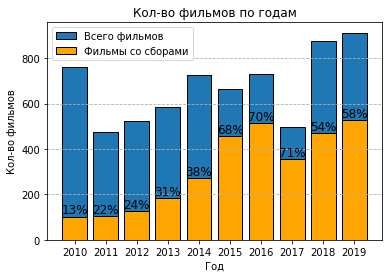

In [85]:
# Постоим гистограмму с указанием % фильмов со сборами

# Объявляем переменные  fig (данные по аннатоции) и ax (данные по осям/значениям)
fig, ax = plt.subplots() 

# Создаем общий график распределения кол-ва фильмов по годам
# general_hist = films_by_year.plot(kind='bar', edgecolor='black') 
general_hist = ax.bar(films_by_year.index, films_by_year.values, 
                      edgecolor='black', label='Всего фильмов') 
# Выбираем столбчатый график т.к. значения подсчитаны и надо только отобразить на осях
# edgecolor - окантовка 
ax.grid(axis='y', linestyle='--', linewidth=0.8) # отображение сетки по оси y
# Ограничение отображения оси X только указанными значениями и подписи всех
plt.xticks(films_by_year.index) 

# Выделяем процент данных внутри каждого столбца
# Проходим по столбцам и каждому столбцу присваиваем индекс по порядку
for i, bar in enumerate(general_hist): 
    year = films_by_year.index[i] # Записываем год в переменную
    period_percent = box_by_year[year] # Записываем кол-во фильмов со сборами
    # Выделяем цветом часть столбца, соответствующую проценту данных
    bar_year = ax.bar(year, period_percent, color='orange', 
           edgecolor='black')
    # Добавляем текст с процентами на гистограмму
    percent = percent_box_films[year]
    ax.text(year, period_percent, f"{percent:.0f}%", ha='center', va='bottom',
            fontsize=12)

# Добавление легенды
ax.legend(('Всего фильмов', 'Фильмы со сборами'))

# Добавляем названия
ax.set_xlabel('Год')
ax.set_ylabel('Кол-во фильмов')
ax.set_title('Кол-во фильмов по годам');


**Промежуточный вывод:** <br>
* Для более точного анализа сборов необходимо учитывать, что данные распределены неравномерно: более полная информация представлена в последние годы. В связи с этим, для анализа мы **будем опираться** на период, где объем данных составляет более 50% — с 2015 по 2019 годы включительно.

#### Шаг 3.2. Анализ динамики проката по годам

In [86]:
# Исключаем из выборки значение -1 в столбце 'box_office'
pivot_box_year = data[data['box_office']>0].pivot_table(index='year_show', 
                                            values='box_office', aggfunc='sum').reset_index()

pivot_box_year['box_office'] = pivot_box_year['box_office']/(10**6) # переводим в млн руб
pivot_box_year.rename(columns={'year_show':'Год проката', 'box_office':'Сборы в млн.руб'})

,Год проката,Сборы в млн.руб
0,2010,2.480769
1,2011,14.05065
2,2012,6.955423
3,2013,29.837752
4,2014,7434.679797
5,2015,38513.777762
6,2016,46742.21186
7,2017,48458.147254
8,2018,49251.991405
9,2019,48278.101956


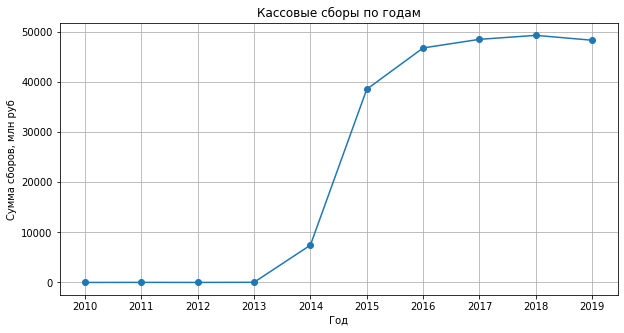

In [87]:
# Построим график изменения сборов по годам
pivot_box_year.plot(x='year_show', y='box_office', style='-', grid=True, figsize=(10,5),
          legend=False, xticks=(pivot_box_year['year_show']), marker='o', 
         title='Кассовые сборы по годам', xlabel='Год', ylabel='Сумма сборов, млн руб');

**Промежуточный вывод:** <br>
* Данные до 2015 года выглядят нереалистично. <br>
* После 2015 года в целом наблюдается небольшой рост, который может быть связан как с увеличением качества сбора данных, инфляцией (изменением средней цены билета и/или общим улучшением экономической ситуации в регионе), увеличением спроса или выходом в прокат большего числа 'блокбастеров'. Точнее определить причины, без валидации данных по сборам, нет возможности. <br>
* Максимальные сборы составили в 2018 году, порядка 49 млрд руб.<br>
* Минимальные значения сборов точно определить нет возможности (требуется валидация данных). <br>
* Очень не хватает данных по количеству зрителей (годовое). Кол-во зрителей позволить понять увеличился/уменьшился интерес к просмотру фильмов или изменились финансовые показатели, что сказалось на общих сборах.

#### Шаг 3.3. Анализ средних и медианных сборов по годам

In [88]:
# Исключаем из выборки значение -1 в столбце 'box_office'
pivot_box_year_mm = data[data['box_office']>0].pivot_table(index='year_show', 
                                       values='box_office', aggfunc=('mean','median')
                                                          ).round(2).reset_index()
pivot_box_year_mm['mean'] = pivot_box_year_mm['mean']/(10**6) # переводим в млн руб
pivot_box_year_mm['median'] = pivot_box_year_mm['median']/(10**6) # переводим в млн руб
pivot_box_year_mm.rename(columns={'year_show':'Год проката', 
                                   'mean':'Ср. сборы в млн.руб', 
                                   'median':'Мед. сборы в млн.руб'})

,Год проката,Ср. сборы в млн.руб,Мед. сборы в млн.руб
0,2010,0.025314,0.001868
1,2011,0.132553,0.002952
2,2012,0.056548,0.00622
3,2013,0.166691,0.00358
4,2014,27.845243,0.02249
5,2015,85.207473,4.864744
6,2016,91.293383,4.019918
7,2017,136.501823,9.919415
8,2018,104.568984,8.751896
9,2019,91.262953,4.601034


Медианные значения низкие, даже для 2015+ годов. Возможно, это связано распределением сборов в киноиндустрии. Проверим эту гипотезу на 2017 году (как самому заполненном по количеству данных)

In [89]:
# Разобьем данные сборов в 2017 года на 10 равных частей
distrib_2017 = pd.cut(data[(data['year_show']==2017) & (data['box_office']>0)]['box_office'], 10)
distrib_2017.value_counts().reset_index().sort_values('box_office') #вывод

,index,box_office
8,"(1667814846.4, 1945782670.8]",0
9,"(2223750495.2, 2501718319.6]",0
6,"(1945782670.8, 2223750495.2]",1
7,"(2501718319.6, 2779686144.0]",1
5,"(1111879197.6, 1389847022.0]",3
4,"(1389847022.0, 1667814846.4]",4
3,"(833911373.2, 1111879197.6]",9
2,"(555943548.8, 833911373.2]",14
1,"(277975724.4, 555943548.8]",20
0,"(-2771778.244, 277975724.4]",303


<a name='median_dependence'> </a>
Гипотеза потвердилась, абсолютное большинство фильмов имеют 10% сборов. Остальные 90% сборов распределены между немногими фильмами (около 17% фильмов по 2017 году). 

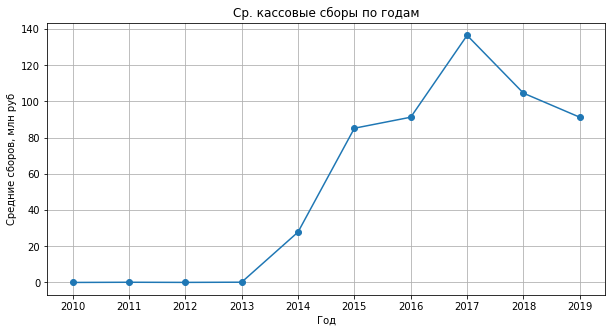

In [90]:
# Построим график изменения средних сборов по годам
pivot_box_year_mm.plot(x='year_show', y='mean', style='-', grid=True, figsize=(10,5),
          legend=False, xticks=(pivot_box_year['year_show']), marker='o', 
         title='Ср. кассовые сборы по годам', xlabel='Год', ylabel='Средние сборов, млн руб');

Динамика средних значений сборов также подтверждает тезис что до 2015 года качество данных очень низкое и анализ этого периода нет возможности провести по предоставленным данным.<br>
Значения после 2015 года во многом похожи на динамику суммарных сборов. Отклонения вызваны неравномерностью сборов между 'блокбастерами' и 'типовыми' фильмами. [Подробнее](#median_dependence) про неравномерность в оценке медианных значений.

**Промежуточный вывод:** <br>
* Данные повторяют динамику общих сборов.
* Из-за особенностей рынка кинопроката медианные значения не показательны.

#### Шаг 3.3. Анализ влияния возрастного рейтинга

In [91]:
# Создадим сводную таблицу с суммарными сборами по возрастным категориям для 2015+ годов
pivot_age_impact_sum = data[(data['year_show']>2014) & (data['box_office']>0)].pivot_table(
    index='age_restriction', columns='year_show',
     values='box_office', aggfunc='sum', margins=True, margins_name='sum'
                                                          )
pivot_age_impact_sum = pivot_age_impact_sum/(10**6) # переводим все значения в млн руб
pivot_age_impact = pivot_age_impact_sum.drop('sum', axis=1).drop('sum') # отдельно сделаем без сумм

pivot_age_impact_sum

,2015,2016,2017,2018,2019,sum
age_restriction,,,,,,
«0+» - для любой зрительской аудитории,4556.252754,3919.124436,6232.311143,1502.522923,2962.35519,19172.566446
«12+» - для детей старше 12 лет,10752.71572,13715.344653,4255.45941,11907.900922,15762.486435,56393.90714
«16+» - для детей старше 16 лет,11602.664078,16815.336897,17984.832847,18028.579109,15875.369054,80306.781985
«18+» - запрещено для детей,9010.91223,9389.549667,12288.79516,12895.650585,5387.461885,48972.369527
«6+» - для детей старше 6 лет,2591.23298,2902.856207,7696.748694,4917.337866,8290.429392,26398.605139
sum,38513.777762,46742.21186,48458.147254,49251.991405,48278.101956,231244.230237


In [92]:
# Выведем рейтинг с максимальным общим сбором за период
pivot_age_impact_sum[pivot_age_impact_sum['sum']==pivot_age_impact_sum.drop('sum')['sum'].max()]

,2015,2016,2017,2018,2019,sum
age_restriction,,,,,,
«16+» - для детей старше 16 лет,11602.664078,16815.336897,17984.832847,18028.579109,15875.369054,80306.781985


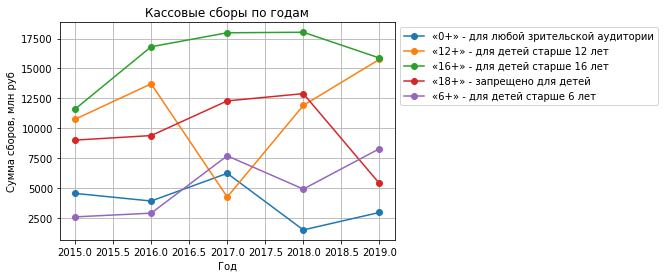

In [93]:
# Выведем график по сборам для каждой возрастной категории 
pivot_age_impact.T.plot(style='-', grid=True, 
          legend=True, marker='o',
         title='Кассовые сборы по годам', xlabel='Год', ylabel='Сумма сборов, млн руб');
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', );

Фильмы с рейтингом 16+ больше собирают сборов. Возможно это связано с [количеством](#Столбец-'age_restriction') таких фильмов. Проверим эту гипотезу и изучим средние показатели сборов. 

In [94]:
# Создадим сводную таблицу с средними сборами по возрастным категориям для 2015+ годов
pivot_age_impact_mean = data[(data['year_show']>2014) & (data['box_office']>0)].pivot_table(
    index='age_restriction', columns='year_show',
     values='box_office', aggfunc='mean'
                                                          )
pivot_age_impact_mean = pivot_age_impact_mean/(10**6) # переводим все значения в млн руб

pivot_age_impact_mean

year_show,2015,2016,2017,2018,2019
age_restriction,,,,,
«0+» - для любой зрительской аудитории,74.692668,63.211684,259.679631,48.468481,74.05888
«12+» - для детей старше 12 лет,106.462532,119.263867,59.103603,113.40858,117.630496
«16+» - для детей старше 16 лет,80.574056,90.893713,127.552006,108.605898,81.412149
«18+» - запрещено для детей,90.109122,86.142657,159.594742,100.74727,50.825112
«6+» - для детей старше 6 лет,56.331152,70.801371,187.725578,119.93507,153.52647


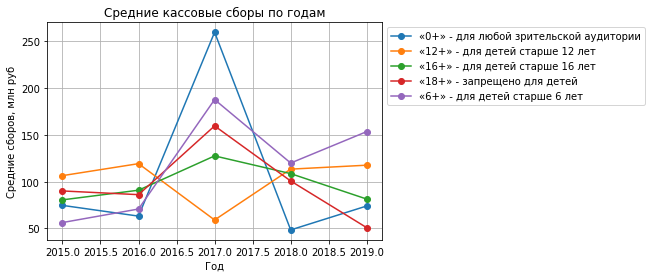

In [95]:
# Выведем график по сборам для каждой возрастной категории 
pivot_age_impact_mean.T.plot(style='-', grid=True, 
          legend=True, marker='o',
         title='Средние кассовые сборы по годам', xlabel='Год', ylabel='Средние сборов, млн руб');
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', );

In [96]:
# Создадим сводную таблицу с количеством фильмов по возрастным категориям для 2015+ годов
pivot_age_impact_count = data[(data['year_show']>2014) & (data['box_office']>0)].pivot_table(
    index='age_restriction', columns='year_show',
     values='title', aggfunc='count', margins=True, margins_name='sum')

pivot_age_impact_count

year_show,2015,2016,2017,2018,2019,sum
age_restriction,,,,,,
«0+» - для любой зрительской аудитории,61,62,24,31,40,218
«12+» - для детей старше 12 лет,101,115,72,105,134,527
«16+» - для детей старше 16 лет,144,185,141,166,195,831
«18+» - запрещено для детей,100,109,77,128,106,520
«6+» - для детей старше 6 лет,46,41,41,41,54,223
sum,452,512,355,471,529,2319


По средним сборам самые успешными являются фильмы с рейтингом 6+ лет. При этом в поздние года сборы увеличились для меньшей возрастной категории. Большая волатильность рейтинга 0+ связана с малой выборкой и увеличением влияния конкретных фильмов. 

**Промежуточный вывод:** <br>
* По общему сбору заметно выше фильмы с рейтингом 16+. Это связано с [количество](#Столбец-'age_restriction') таких фильмов.
* По средним сборам начинают преобладать фильмы с рейтингом 6+. Причем прослеживается тенденция к увеличению средних сборов для категорий 6+ и 12+.
* В зависимости от года прослеживается большая волатильность данных, обусловленная [влиянием 'блокбастеров'](#median_dependence).

#### Шаг 3.4. Анализ влияния основного жанра

In [97]:
# Создадим сводную таблицу с суммарными сборами по основным жанрам для 2015+ годов
pivot_genre_impact_sum = data[(data['year_show']>2014) & (data['box_office']>0
                                    ) & (data['genres_first']!='no_data')].pivot_table(
    index='genres_first', columns='year_show',
     values='box_office', aggfunc='sum', margins=True, margins_name='sum'
                                                          )
pivot_genre_impact_sum = pivot_genre_impact_sum/(10**6) # переводим все значения в млн руб
pivot_genre_impact = pivot_genre_impact_sum.drop('sum', axis=1).drop('sum') # отдельно сделаем без сумм

pivot_genre_impact_sum

,2015,2016,2017,2018,2019,sum
genres_first,,,,,,
аниме,23.324378,<NA>,34.163829,1260.428874,85.916155,1403.833236
биография,441.033733,5.17076,<NA>,1210.874831,245.039437,1902.118761
боевик,7513.012462,4995.436972,4074.392842,6352.825882,3422.790632,26358.45879
вестерн,399.913055,<NA>,<NA>,<NA>,1.825289,401.738344
военный,35.305096,415.327791,324.707512,564.508862,320.014115,1659.863376
детектив,72.618367,<NA>,925.790577,986.306759,469.102868,2453.818571
детский,1.03852,2.629235,<NA>,<NA>,<NA>,3.667755
для взрослых,<NA>,0.77421,<NA>,<NA>,<NA>,0.77421
документальный,26.446019,13.657291,21.928014,45.135545,115.771778,222.938647


In [98]:
# Выведем 5 жанров с максимальным общим сбором за период
pivot_genre_impact_sum.drop('sum').sort_values('sum', ascending=False).head()

,2015,2016,2017,2018,2019,sum
genres_first,,,,,,
фантастика,9794.353601,11053.91126,8883.071567,11051.021423,9108.68875,49891.046601
мультфильм,5545.35503,8759.273908,6962.018469,5794.965913,8958.46594,36020.07926
боевик,7513.012462,4995.436972,4074.392842,6352.825882,3422.790632,26358.45879
фэнтези,1160.608592,8249.383108,6081.331053,3212.390534,5049.840208,23753.553495
комедия,4008.586197,2682.528068,4290.313628,4745.234559,7367.659546,23094.321998


Больше всего сборов обеспечил жанр фантастика. Проверим влияния количества.

In [99]:
# Создадим сводную таблицу с средними сборами по основному жанру для 2015+ годов
pivot_genre_impact_mean = data[(data['year_show']>2014) & (data['box_office']>0
                                    ) & (data['genres_first']!='no_data')].pivot_table(
    index='genres_first', columns='year_show', values='box_office', aggfunc='mean')
                            
pivot_genre_impact_mean = pivot_genre_impact_mean/(10**6) # переводим все значения в млн руб

pivot_genre_impact_mean

year_show,2015,2016,2017,2018,2019
genres_first,,,,,
аниме,11.662189,<NA>,34.163829,157.553609,7.15968
биография,220.516866,2.58538,<NA>,172.982119,27.226604
боевик,220.970955,128.088127,119.835084,135.166508,122.242523
вестерн,199.956527,<NA>,<NA>,<NA>,1.825289
военный,8.826274,207.663895,162.353756,141.127216,80.003529
детектив,36.309184,<NA>,231.447644,140.900966,93.820574
детский,0.51926,0.657309,<NA>,<NA>,<NA>
для взрослых,<NA>,0.77421,<NA>,<NA>,<NA>
документальный,2.034309,0.620786,3.132573,2.256777,4.823824


In [100]:
# Выведем 5 жанров с максимальным средним сбором за период (посредством индекса)
pivot_genre_impact_mean.T.sum().sort_values(ascending=False).head(5)

спорт         2959.813491
фантастика    1892.278591
фэнтези       1302.946132
мюзикл        1148.201950
история       1116.543338
dtype: float64

**Промежуточный вывод:** <br>
* По общему сбору заметно выше фильмы жанров "фантастика" и "мультфильм". Это связано с количество таких фильмов.
* По средним сборам начинают преобладать фильмы с жанрами "спорт", "фантастика", "фэнтези", "мюзикл" и "история".

### Шаг 4. Иследуем фильмы, которые получили государственную поддержку

#### Шаг 4.1. Общие данные по фильмам с гос поддержкой

In [101]:
pivot_gov_sup = data[data['budget'].notna()].pivot_table(index='year_show', 
                values=('refundable_support', 'nonrefundable_support', 'budget', 'box_office'),
                aggfunc='sum', margins=True, margins_name='sum'            
                                        )

pivot_gov_sup = pivot_gov_sup/(10**6) # переводим значения в млн руб
pivot_gov_sup 

,box_office,budget,nonrefundable_support,refundable_support
year_show,,,,
2013,20.322386,255.43539,134.347945,0.0
2014,1007.18815,1279.484783,478.002299,71.0
2015,4815.747418,7309.669207,2680.08834,547.153119
2016,4957.724367,7228.942748,3074.655482,902.5
2017,10759.515337,6972.172568,2424.624781,674.346881
2018,9517.657284,6651.694634,2506.0,592.0
2019,8262.02063,12542.866609,3856.0,868.0
sum,39340.175572,40586.168158,14404.198847,3515.0


In [102]:
data['part_gov_support'].describe()

count     315.0
unique    258.0
top        70.0
freq       14.0
Name: part_gov_support, dtype: float64

In [103]:
# Сколько % фильмов не смогли вернуть возвратную  часть финансирования
not_return = data[data['budget'].notna()].query('box_office < refundable_support', 
                                                engine='python')
''' Явно указываем движок выполнения Python, чтобы исключить 
предупреждение о вынужденном переходе на него (numexpr не поддерживает тип Int64).
В итоге увеличивается время обработки, но для этой задачи это не критично '''

# Выводим % фильмов, которые не смогли вернуть возвратную  часть
not_return.shape[0] / data[data['budget'].notna()].shape[0] *100 

8.253968253968253

In [104]:
# Определим фильмы с гос участием, которые полностью окупили свой бюджет
full_return = data[data['budget'].notna()].query('box_office > budget', 
                                                engine='python')
full_return.shape[0] / data[data['budget'].notna()].shape[0] *100 

20.952380952380953

**Общие данные по фильмам с государственным финансированием:**
- Гос финансирование указано для 315 фильмов <br>
- Общий бюджет фильмов, получивших государственную поддержку, составил 42,24 млрд рублей, из которых 15,153 млрд рублей — это невозвратные средства, а 3,655 млрд рублей — возвратные. При оценке финансового успеха следует учитывать, что некоторые фильмы могли иметь некоммерческую направленность (культурную, образовательную и т.д.), и их окупаемость изначально не была запланирована. <br>
- 8,25% фильмов (26 шт) не смогли вернуть возвратную часть гос финансирования
- 20.95% фильмов (66 шт) с гос финансированием полностью окупили свой бюджет
- Общие кассовые сборы составляют 39,34 млрд руб <br>
- Средний процент участия государства в бюджете фильма 51%, минимальный 4,4%, максимальный 78,47% <br>
- До 2015 года значения также выбиваются


#### Шаг 4.2. Влияние жанра на окупаемость возратной части

In [105]:
# Самые частыe жанры с гос финансированием
data[data['budget'].notna()]['genres_first'].value_counts().head()

драма         92
комедия       68
мультфильм    26
no_data       16
триллер       14
Name: genres_first, dtype: int64

In [106]:
# Не окупают возратную часть
not_return['genres_first'].value_counts().head()

драма      6
комедия    6
мюзикл     3
триллер    2
no_data    2
Name: genres_first, dtype: int64

In [107]:
# Окупают возратную часть

# Получаем список фильмов которые окупили возращаемую часть
title_films_nr = not_return['title_replace']
refund_return = data[data['budget'].notna()].query('title_replace not in @title_films_nr')

refund_return['genres_first'].value_counts().head()

драма         86
комедия       62
мультфильм    25
no_data       14
мелодрама     13
Name: genres_first, dtype: int64

**Выборка слишком маленькая, чтобы делать выводы по жанрам** <br>
Общее распределение равномерное (с учетом влияния 1 усл.ед. на относительные значения)

#### Шаг 4.3. Распределение по фондам финансирования

In [108]:
pivot_fund = data[data['budget'].notna()].pivot_table(index='financing_source', 
                values=('refundable_support', 'nonrefundable_support', 'budget', 'box_office'),
                aggfunc='sum')

pivot_fund = pivot_fund/(10**6) # переводим значения в млн руб

# Добавим окупаемость от общего бюджета по сборам, в %
pivot_fund['payback, %'] = pivot_fund['box_office']/pivot_fund['budget']*100

pivot_fund 

,box_office,budget,nonrefundable_support,refundable_support,"payback, %"
financing_source,,,,,
Министерство культуры,5306.6554,11469.203758,4830.661,0.0,46.268734
"Министерство культуры, Фонд кино",795.104402,2626.309609,836.931354,325.5,30.274588
Фонд кино,33238.41577,28144.752572,9486.126493,3329.5,118.098092


* Министерство культуры выделяет только безвозвратную финансовую поддержку. 
* Общая окупаемость фильмов с поддержкой от Фонда кино 118% 
* Общая окупаемость фильмов с поддержкой от Министерства культуры всего 46%, но задачи окупить перед не ставилось.

#### Шаг 4.4. Объем выделяемой гос поддержки по годам

In [109]:
# Добавляем данные по общей гос поддержке в pivot_gov_sup 
pivot_gov_sup['full_support'] = pivot_gov_sup['nonrefundable_support'] + \
            pivot_gov_sup['refundable_support']
pivot_gov_sup

,box_office,budget,nonrefundable_support,refundable_support,full_support
year_show,,,,,
2013,20.322386,255.43539,134.347945,0.0,134.347945
2014,1007.18815,1279.484783,478.002299,71.0,549.002299
2015,4815.747418,7309.669207,2680.08834,547.153119,3227.241459
2016,4957.724367,7228.942748,3074.655482,902.5,3977.155482
2017,10759.515337,6972.172568,2424.624781,674.346881,3098.971662
2018,9517.657284,6651.694634,2506.0,592.0,3098.0
2019,8262.02063,12542.866609,3856.0,868.0,4724.0
sum,39340.175572,40586.168158,14404.198847,3515.0,17919.198847


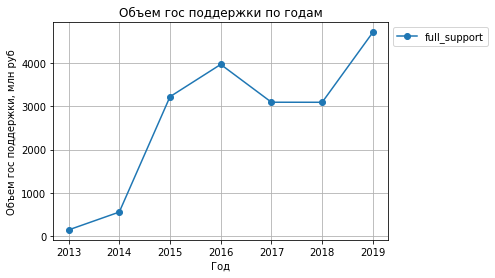

In [110]:
# Выведем график по сборам для каждой возрастной категории 
pivot_gov_sup.drop('sum')['full_support'].plot(
        style='-', grid=True, legend=True, marker='o',
      title='Объем гос поддержки по годам', xlabel='Год', ylabel='Объем гос поддержки, млн руб');
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');

Общий объем финансирования имеет незначительную тенденцию к увеличению (данные до 2015 года исключаем из-за их недостоверности). Есть предположение, что объем выделяемых средств обратно пропорционален общим сбором кинопроката.

In [111]:
# Объеденяем данные из двух таблиц по ключу 'year_show'
table_temp = pivot_gov_sup.drop('sum').reset_index().merge(
    pivot_box_year,
    on='year_show', how='left', suffixes=('', '_2')).query('year_show >= 2015')
# Определяем коэф. корреляции между выделением средств гос поддержки и общим сбором средств фильмов
# для фильмов с 2015 года. Т.к. есть выбросы, то лучше использовать метод Спирмена
table_temp['box_office_2'].corr(table_temp['full_support'], method='spearman') # корреляция Спирмена 				

-0.6

In [112]:
# Также проверим корреляцию между объемом гос поддержки и сборами фильмов с поддержкой
table_temp['box_office'].corr(table_temp['full_support'], method='spearman')

-0.49999999999999994

Действительно прослеживается обратная тенденция - чем больше кассовые сборы, тем меньший общий объем гос поддержки. Но надо принимать во внимание малый период выборки (5 лет), что может отображается на коэффициенте. Так что делать выводы по предоставленным данным нельзя. Можно только вывести гипотезу, что чем больше объем кассовых сборов, тем меньше фильмов нуждаются в гос. поддержке.

#### Шаг 4.5. Анализ средней поддержки на фильм

In [113]:
# Выведем кол-во фильмов с гос поддержкой по годам
data[data['budget'].notna()].groupby('year_show')['title'].count()

year_show
2013     2
2014    15
2015    80
2016    58
2017    39
2018    52
2019    69
Name: title, dtype: int64

In [114]:
# Выведем средний объем поддержки на фильм по годам, в млн.руб
pivot_gov_sup['full_support'] / data[data['budget'].notna()].groupby('year_show')['title'].count()

year_show
2013    67.173973
2014    36.600153
2015    40.340518
2016    68.571646
2017    79.460812
2018    59.576923
2019    68.463768
sum           NaN
dtype: Float64

От количества фильмов объем выделяемых средств не зависит. Либо выделяется общий объем на год, с корректировкой для "особых" фильмов, либо вопрос о количестве выделяемых средств на фильм решается индивидуально. Есть совпадения по общему объему за 2017 и 2018 год и по среднему на фильм за 2016 + 2019 год (второе скорее всего случайность, т.к. многие показатели между годами изменились)

#### Шаг 4.6. Анализ рейтинга фильмов с гос поддержкой

In [115]:
# Рассчитаем средний рейтинг всех фильмов и фильмов с гос поддержкой
data['ratings'].mean(), data[data['budget'].notna()]['ratings'].mean()

(5.408068097705403, 5.701587301587302)

Средний рейтинг для всех фильмов и фильмов с гос поддержкой одинаков, около 5-6.

**Промежуточный вывод:** <br>
* Фильмы с государственной поддержкой в среднем окупаются, если изначально ставится такая задача (предусмотрены возвратные средства).
* Оценки зрителей для фильмов с государственной поддержкой, согласно анализу, не изменяются по сравнению с другими фильмами.
* Недостаточно данных по бюджетам фильмов без государственной поддержки для полноценного сравнения показателей окупаемости. 

### Шаг 5. Общий вывод

**Цель работы:** <br> 
Определить тенденции кинопроката в России

**Анализ вводных данных:** <br><br>
Во вводных данных было обнаружено:
- [Пропуски в столбцах](#Шаг-2.2.-Изучим-пропуски-в-датафрейме). По возможности пропуски были заполнены, либо оставлены без изменений (столбец 'budget' и 'box_office')
- [Дубликаты](#Шаг-2.3.-Изучим-дубликаты-в-датафрейме-и-удалим-их-по-необходимости) (731 шт) были удалены, за исключением разницы в сроках показа более 1 года и наличием указанных сборов.
- Аномальные значения были обработаны на этапе изучения [категориальных данных](#Шаг-2.4.-Изучим-категориальные-значения) и [количественных данных](#Шаг-2.5.-Проверим-количественные-значения). Были удалены 17 строк, где указано гос поддержка, но значения бюджет были пусты.
- [Данные](#Столбец-'box_office') по кассовым сборам ('box_office') имеют нерелевантные значения. Особенно заметно на годах до 2015. Данные по сборам до 2015 года не подлежат анализу. **Для проверки данных по кассовым сборам необходимо произвести полную валидацию данных.** 
- Обнаружена ошибка в Техническом Задании. Столбец 'show_start_date' содержит данные по дате выдачи прокатного удостоверения, а не премьеру фильма (как указано в ТЗ). [Подробнее](#Дополнительно-по-дате.).
- Обнаружена ошибка - дублирование номера прокатного удостоверения 221054410 и 221154310

**Анализ тенденций кинопроката в России:**<br><br>
- Общее количество кинофильмов в прокате растет.
- Общие кассовые сборы стабилизировались на уровне 48 млрд рублей и показывают признаки стагнации.
- Средние показатели сборов на фильм показывают небольшое падение.
- Небольшая доля фильмов (15-20%) аккумулирует около 90% всех сборов, в то время как оставшиеся фильмы распределяют между собой лишь 10%. Из-за этого медианные значения не могут адекватно отражать общую картину.
- В кинопрокате большая зависимость от конкретных фильмов (характерная черта всех цифровых продуктов). Это связано с большими затратами на разработку и малыми затратами на масштабирование продукта.
- Большая часть сборов приходится на фильмы с возрастным рейтингом 16+, что объясняется их доминирующим количеством в прокате.
- По средним сборам прослеживается тенденция к увеличению сборов для возрастных категорий 6+ и 12+ лет и преобладают фильмы с рейтингом 6+ лет.
- Отмечается значительная волатильность данных, что связано с [влиянием крупных релизов ("блокбастеров")](#median_dependence) и неравномерным распределением фильмов по возрастным рейтингам.
- По общему сбору лидируют фильмы жанров "фантастика" и "мультфильм". Это связано с количество таких фильмов.
- По средним сборам начинают преобладать фильмы с жанрами "спорт", "фантастика", "фэнтези", "мюзикл" и "история".
- Оценка тенденций на основе только финансовых показателей затруднена из-за значительного влияния внешних экономических факторов.

**Анализ государственной поддержки кинопроката в России:**<br><br>
- 8,25% фильмов (26 шт.) не смогли вернуть возвратную часть финансирования.
- 20,95% фильмов (66 шт.), получивших государственное финансирование, полностью окупили свой бюджет.
- Общая окупаемость фильмов с поддержкой от Фонда кино составляет 118%.
- Общая окупаемость фильмов с поддержкой Министерства культуры всего 46%, однако перед ними не ставилась задача окупаемости.
- Средний рейтинг всех фильмов, включая фильмы с государственной поддержкой, остается на уровне 5-6 баллов.
- Недостаточно данных по бюджетам фильмов без государственной поддержки для полноценного сравнения показателей окупаемости.

**Рекомендации:** <br><br>
- Провести валидацию данных
- Дополнить данными (начать собирать) год выпуска фильма, количество зрителей
- Собирать данные по бюджету и другим открытым показателям не только для кино с государственной поддержкой, но и для фильмов с частным финансированием
- Разделить фильмы на категории по предполагаемому воздействию на культуру, общественные ценности и социальные аспекты (по необходимости, разработать методологию по классификации)
- Решение по выделению поддержки коммерческих фильмов принимать на основе актуальности жанра или темы, которые в данный момент интересны зрителю. 